In [1]:
import numpy  as np
import pandas as pd

import math
import time

from collections import Counter
from IPython.display import HTML

In [2]:
ciphers_df = pd.read_csv('test.csv')
ciphers_df = ciphers_df.query("difficulty==1")
ciphers_df['length'] = ciphers_df['ciphertext'].apply(lambda x: len(x))
ciphers_df.head()

,ciphertext_id,ciphertext,difficulty,length
2,ID_f6479f2ee,}8E U%Weuoc1'8fdsc.:L5DTtKii2RMDV6VpnST264P:[m...,1,1800
4,ID_20187e596,N*VV$-C${E$?H=103EH1a7Ov#l=7Gv#l7!o72l#lQ7o!Ol...,1,800
9,ID_f5670350b,tuey%v.HzU9#!tegGOa7Ql4OOV7O!Wl=7x[!o7z!OCX7il...,1,600
10,ID_71621a965,"e)'K=(%{!q,xy4OOV(7!xo7[4Q=7xv7=lo,Q!Fl7}[4xo7...",1,1100
12,ID_92f5ceac5,"%z%zY Xzsbm3Cbmo15c7}%-Mu/6c#):X,K?Y9p[sf!f@%K...",1,700


In [3]:
plaintext_df = pd.read_csv("training.csv", index_col='index')
plaintext_df['length'] = plaintext_df['text'].apply(lambda x: len(x))
plaintext_df['padded_length'] = (np.ceil(plaintext_df['length'] / 100) * 100).astype(int)
plaintext_df.head()

,plaintext_id,text,length,padded_length
index,,,,
1228,ID_2ed3c75e8,Saying Bambi 2 is better than the original is ...,627,700
22903,ID_d51637e35,I detest slapstick and even as a child I could...,962,1000
44844,ID_096b6847e,If you want to see a movie about things that w...,525,600
10556,ID_3f2297975,"The Flesh and the Fiends, also known as Mania,...",2779,2800
18562,ID_9431252bd,I am at a loss of words after watching this on...,894,900


In [4]:
plaintext_corpus = ''.join(list(plaintext_df['text']))
ciphrtext_corpus = ''.join(list(ciphers_df['ciphertext']))

In [5]:
def count_characters(text):
    counter = Counter(text)
    df = pd.DataFrame(list(counter.items()), columns=['Character', 'Count'])
    df['Percent'] = df['Count'] / df['Count'].sum()
    df_sorted = df.sort_values(by='Count', ascending=False)
    return df_sorted

In [6]:
def display_counts(plain_counts, ciphr_counts, n=5):
    plain_html = wrap_html("PlainText", plain_counts, n)
    ciphr_html = wrap_html("Cipher",    ciphr_counts, n)
    display(HTML(plain_html + ciphr_html))

def wrap_html(name, df, n):
    return \
        "<div style='float: left; padding: 10px;'>" + \
            "<h3>" + name + "</h3>" + \
            df[:n].to_html() + \
            "..." + \
            df[-n:].to_html() + \
            str(df.shape) + \
        "</div>"

In [7]:
plaintext_counts = count_characters(plaintext_corpus)
ciphrtext_counts = count_characters(ciphrtext_corpus)

display_counts(plaintext_counts, ciphrtext_counts)

,Character,Count,Percent
6,,9828087,0.178850
12,e,5147082,0.093666
13,t,3893102,0.070846
1,a,3393188,0.061749
16,o,3207672,0.058373
,Character,Count,Percent
80,],191,0.000003
79,[,185,0.000003
83,},136,0.000002
84,@,135,0.000002


In [8]:
class SubstitutionCipher:
    def __init__(self, plain_alphabet, ciphr_alphabet):
        self.decrypt_mapping = {}
        self.encrypt_mapping = {}
        
        for p, c in zip(plain_alphabet, ciphr_alphabet):
            self.update(p, c)

    def update(self, p, c):
        self.decrypt_mapping[c] = p
        self.encrypt_mapping[p] = c

    def encrypt(self, text):
        return self.substitute(text, self.encrypt_mapping)
    
    def decrypt(self, text):
        return self.substitute(text, self.decrypt_mapping)
    
    def substitute(self, text, mapping):
        result = [
            mapping[c]
            for c in list(text)
        ]
        return ''.join(result)

Let's try decrypting one of the ciphers:

In [9]:
substitution = SubstitutionCipher(plaintext_counts['Character'], ciphrtext_counts['Character'])
substitution.decrypt(ciphers_df.iloc[2]['ciphertext'])

"@]SuXo{qf7Gvi@SFLlI really liked this film. Kevin Hostner and, for that matter, the whole cast was outstanding. jennis Quaid was exceptional and surely deserved more recognition from the critics than he received. My obDections to the film must be laid at the door of Kasdan...it could have been edited with a sharper hand. I underAstand the desire to expand the story to it's fullest but many minutes could have been cut during the manhunt at the railway station and the end scenes done in retrospect weren't necessary. More careful editing might have saved the day on a fine film.Kt[I@yFz N22A#F0!p%"

In [10]:
alphabet_per_cipher = [ set(text) for text in list(ciphers_df['ciphertext'].str[50:-50])]
character_presence  = pd.DataFrame([
    {
        c: c in alphabet
        for c in ciphrtext_counts['Character'].values
    }
    for alphabet in alphabet_per_cipher
], index=ciphers_df.index)
character_presence.head()

,7,l,x,4,v,!,o,2,Q,[,...,%,$,-,r,L,u,B,R,t,.
2,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
9,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
10,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
12,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [11]:
character_presence.any().all()

True

In [12]:
subset_indexes = [2]

while not character_presence.loc[subset_indexes].any().all():
    ant = character_presence.loc[subset_indexes].any()
    unfound_characters = ant[ant == False]
    unfound_character  = unfound_characters.index[0]
    found_here = character_presence[character_presence[unfound_character]].index[0]
    subset_indexes.append(found_here)

display(len(subset_indexes))
display(subset_indexes)

16

[2, 9, 10, 4, 12, 54, 122, 15, 130, 80, 208, 263, 974, 933, 2261, 2299]

In [13]:
from sklearn.model_selection import *
from lib.utils import *
X,y=extract_feature(alphabet_per_cipher)
X_train,X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.25, 
                                   shuffle=True)
ac=[]

In [14]:
from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ac.append(accuracy_score(y_pred,y_test,sample_weight=0.8)*100)

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import numpy as np

np.random.seed(1000)


AlexNet = Sequential()


AlexNet.add(Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))


AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))


AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))


AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))


AlexNet.add(Flatten())

AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Dropout(0.4))


AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Dropout(0.4))


AlexNet.add(Dense(10))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))


AlexNet.summary()
ac.append(accuracy_score(y_test,AlexNet,sample_weight=0.4)*100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 96)          384       
_________________________________________________________________
activation (Activation)      (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 256)         0

In [16]:
len(ciphers_df) / len(plaintext_df)

0.250346895841726

In [17]:
plaintext_df['encrypt1'] = plaintext_df['text'].apply(lambda text: substitution.encrypt(text))
plaintext_df.to_csv('plaintext_encrypt1.csv')
plaintext_df.head()

,plaintext_id,text,length,padded_length,encrypt1
index,,,,,
1228,ID_2ed3c75e8,Saying Bambi 2 is better than the original is ...,627,700,e4V!2:7*4CF!7M7!o7FlxxlQ7x[427x[l7vQ!:!24O7!o7...
22903,ID_d51637e35,I detest slapstick and even as a child I could...,962,1000,"a7=lxlox7oO4dox!,W742=7l#l274o747,[!O=7a7,vyO=..."
44844,ID_096b6847e,If you want to see a movie about things that w...,525,600,az7Vvy7}42x7xv7oll747Cv#!l74Fvyx7x[!2:o7x[4x7}...
10556,ID_3f2297975,"The Flesh and the Fiends, also known as Mania,...",2779,2800,/[l7gOlo[742=7x[l7g!l2=o(74Oov7W2v}274o7J42!4(...
18562,ID_9431252bd,I am at a loss of words after watching this on...,894,900,"a74C74x747Ovoo7vz7}vQ=o74zxlQ7}4x,[!2:7x[!o7v2..."


the accuracy of AlexNet is 94.489 and KNN is 93.30000000000001


C:\Users\thiru\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Agorithms,accuracy
0,AlexNet,94.489
1,KNN,93.300


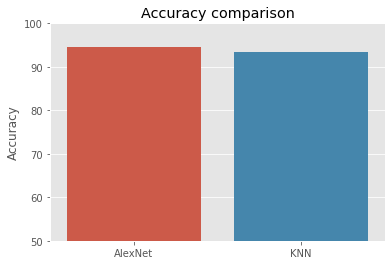

In [18]:
import numpy as np
import seaborn as sns
import matplotlib as plt

plt.style.use('ggplot')
x=['AlexNet','KNN']
ac.reverse() 
ax=sns.barplot(x,ac[:2])
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')
#ax.yaxis.set_major_locator(ticker.LinearLocator())
print("the accuracy of {} is {} and {} is {}".format(x[0],ac[0],x[1],ac[1]))
ax.set_ylim(50,100)
data={'Agorithms':x,
     "accuracy":ac}
df=pd.DataFrame(data)
df.head()